<a href="https://colab.research.google.com/github/codyub/ESAA/blob/main/%ED%8C%8C%EC%9D%B4%EC%8D%AC_%EB%94%A5%EB%9F%AC%EB%8B%9D_%ED%85%90%EC%84%9C%ED%94%8C%EB%A1%9C_ch4_5_pg_229~240.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 07 이미지 분할
- 이미지를 구성하는 모든 픽셀에 대해 픽셀 단위로 분류하는 것
- 즉, 모든 픽셀은 어떠한 클래스에 속한다.
ex. 배경 클래스와 객체 클래스로 구성된 이미지가 있다면, 모든 픽셀은 배경 또는 객체 중 하나로 분류 -> 이렇게 모든 픽셀에 대한 정답 클래스 레이블 처리한 데이터셋을 갖고 딥러닝 모델을 훈련시키면 정답 클래스를 알지 못하는 새로운 이미지에 대해서도 배경과 객체를 분리할 수 있다.

# 이미지 분할
- 의미 분할: 같은 범주의 여러 객체를 하나의 범주로 묶어서 구분
- 인스턴스 분할: 같은 범주에 속하더라도 서로 다른 객체를 구분하는 개념


# 7-1 데이터셋 준비


- 반려동눌의 이미지 분류 및 레이블, 각 이미지를 구성하는 픽셀 단위의 마스크로 구성되어 있음
- 여기서 말하는 마스크는 각 픽셀에 대한 범주 레이블을 나타냄
- 각 픽셀은 다음 세 가지 범주 중 하나에 속함
> - 1: 반려동물이 속한 픽셀
> - 2: 반려동물과 인접한 픽셀
> - 3: 위에 속하지 않은 경우/주변 픽셀

# 영상 처리를 위한 OpenCV를 비롯한 필수 라이브러리 불러옴

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pylab as plt
import cv2
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from google.colab.patches import cv2_imshow

- 모델 학습에 필요한 입력 이미지의 크기와 학습 파라미터를 설정
- 이런 방식으로 주요 파라미터를 따로 정리하면 모델의 세부 튜닝 작업을 효율적으로 할 수 있다.

In [2]:
# 이미지 크기
img_w = 128
img_h = 128
img_c = 3
img_shape = (img_w, img_h, img_c)

# 모델 학습
epoch_num = 5
learning_rate = 0.0001
buffer_size = 1000
batch_size = 16

- 텐서플로 데이터셋에서 옥스포드 반려 동물 데이터 셋 불러오기
- 메타 정보를 가져와서 info 변수에 저장

In [3]:
# 텐서플로 데이터셋 로드
ds_str = 'oxford_iiit_pet'
ds, info = tfds.load(name=ds_str, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete20LXRV/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete20LXRV/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [5]:
ds

{'train': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <_PrefetchDataset element_spec={'file_name': TensorSpec(shape=(), dtype=tf.string, name=None), 'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'segmentation_mask': TensorSpec(shape=(None, None, 1), dtype=tf.uint8, name=None), 'species': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [6]:
info

tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_path=PosixGPath('/tmp/tmp87w93bw9tfds'),
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_classes=2),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        

- 원본 이미지와 분할 마스크를 전처리하는 함수를 정의
- 이미지 크기를 사전에 정의한 (128,128) 크기로 변경하고 자료형을 변환
- 원본 이미지 픽셀을 255로 나눠서 0~1 범위로 정규화한다.
- 마스크는 0,1,2의 정수형 값을 갖도록 1을 차감

In [9]:
# 이미지 전처리 함수
def preprocess_image(ds):
  # 원본 이미지
  img = tf.image.resize(ds['image'],(img_w, img_h)) # 이미지 크기 조정
  img = tf.cast(img, tf.float32) / 255.0 # 이미지 자료형 변환
  # 분할 마스크
  mask = tf.image.resize(ds['segmentation_mask'],(img_w, img_h)) # 분할된 이미지 데이터에 대한 처리?
  mask = tf.cast(mask, tf.int32)
  mask = mask - 1
  return img, mask

- CAST 함수는 한 데이터 유형을 다른 호환 가능한 데이터 유형으로 변환합니다. 예를 들어 문자열을 날짜로 변환하거나 숫자 형식을 문자열로 변환할 수 있습니다.

- 앞에서 정의한 전처리 함수를 훈련 셋, 테스트 셋에 매핑해 주고 미니배치로 분할

In [10]:
# 데이터 전처리 파이프라인
train_ds = ds['train'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)
test_ds = ds['test'].map(preprocess_image).shuffle(buffer_size).batch(batch_size).prefetch(2)

print(train_ds)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.int32, name=None))>


- shuffle: 리스트 멤버 섞기, 데이터셋의 순서를 뒤섞는다. 첫번째 매개변수는 buffer_size이다. 한번 섞을 때마다 buffer 크기만큼만 꺼내서 섞는다. reshuffle_each_iteration을 이용해서 매 에포크마다 새로 섞을 수 있다.
- batch: 데이터 샘플들을 배치 단위로 묶어서 새로운 데이터셋을 만들어 준다.
- prefetch: 데이터셋 준비 메서드를 병렬화 해서 다중 스레드로 처리하도록 만들어줌. 넣어주는 매개변수는 버퍼 사이즈를 정한다. 클수록 prefetch를 통해 준비되는 데이터의 수가 많아진다.
- 데이터 파이프라인 tf.data: https://jellyho.com/blog/113/

- 샘플 배치를 한 개 선택
- 배치에는 16개의 샘플 이미지와 마스크 이미지가 들어 있음
- https://dojang.io/mod/page/view.php?id=2408 : iter, next 사용 방법

In [11]:
# 샘플 배치 선택
img, mask = next(iter(train_ds))
len(img)

16

In [12]:
img

<tf.Tensor: shape=(16, 128, 128, 3), dtype=float32, numpy=
array([[[[0.3064951 , 0.38757086, 0.196088  ],
         [0.22272328, 0.24193475, 0.12547679],
         [0.17337814, 0.20069891, 0.07167011],
         ...,
         [0.36508885, 0.34810814, 0.36449715],
         [0.32560316, 0.33635876, 0.2808728 ],
         [0.58412224, 0.5559264 , 0.5078968 ]],

        [[0.33074832, 0.39579695, 0.21089154],
         [0.13173637, 0.13248315, 0.07090227],
         [0.12298369, 0.13266505, 0.06038028],
         ...,
         [0.3879251 , 0.41676432, 0.3215629 ],
         [0.54500616, 0.5616479 , 0.4400678 ],
         [0.495638  , 0.5010589 , 0.43093213]],

        [[0.24676585, 0.31057942, 0.12067632],
         [0.17451555, 0.15694891, 0.14024204],
         [0.18891697, 0.18174212, 0.11104856],
         ...,
         [0.35337391, 0.3930913 , 0.2980488 ],
         [0.44558632, 0.40034276, 0.31568244],
         [0.37142694, 0.35228822, 0.2808766 ]],

        ...,

        [[0.5629079 , 0.52086014,

In [13]:
mask

<tf.Tensor: shape=(16, 128, 128, 1), dtype=int32, numpy=
array([[[[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]],

        [[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]],

        [[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]],

        ...,

        [[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]],

        [[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]],

        [[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]]],


       [[[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]],

        [[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]],

        [[1],
         [1],
         [1],
         ...,
         [1],
         [1],
         [1]],

        ...,

        [[1],

- 배치에서 첫 번째 이미지를 출력
- 0~1 사이의 값이므로, 255를 곱해서 정규화 이전의 원래 값으로 복원

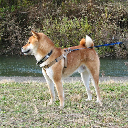

In [14]:
# 샘플 이미지 출력
img = np.array(img[0]) * 255.0
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
cv2_imshow(img)

- 마스크 이미지를 출력
- 마스크 값의 범위는 0~2 이므로, 2로 나눈 다음에 255를 곱하면 RGB 이미지로 표현할 수 있다.

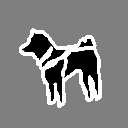

In [15]:
# 샘플 마스크 출력
mask = (np.array(mask[0])/2)*255.0
cv2_imshow(mask)

# U-Net 모델(인코더-디코더)

- 사전 학습된 VGG16 모델을 인코더로 활용하는 U-Net 모델을 만들어본다.
- 이미지넷 경진 대회를 통해 성능이 검증된 모델
- 사전 학습된 모델 덦이 U-Net을 구성하여 학습을 진행해도 학습은 된다. (데이터 개수가 충분하고, 시간이 충분하다는 전제 하에)
- 구글 코랩 환경에서 제한된 자원으로 양호한 성능을 갖는 모델을 만들기 위해서는 사전 학습된 모델을 베이스 모델로 활용하는 전이 학습 방법을 사용하기로 한다.

#  VGG16 모델을 최종 레이어를 제외한 채로 불러옴

In [16]:
# VGG16 모델
base_model = tf.keras.applications.VGG16(input_shape=img_shape, include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


-  VGG16 모델을 합성곱 층과 풀링 층을 직렬로 연결한 구조를 갖음
- 다음 코드의 실행 결과에서 모델 구조를 보면 (128,128) 크기의 텐서가 마지막 레이어에서는 (4,4) 크기로 축소된 것을 확인할 수 있다.
- 이 모델을 U-Net 인코더로 사용할 예정
- 인코더는 원본 이미지 중에서 같은 범주에 속하는 픽셀을 결합하면서 점진적으로 이미지를 더 작은 크기로 축소
- 마스크 정답을 활용하여 각 픽셀의 마스크 범주를 0,1,2 중에서 하나로 분류하는 역할을 함

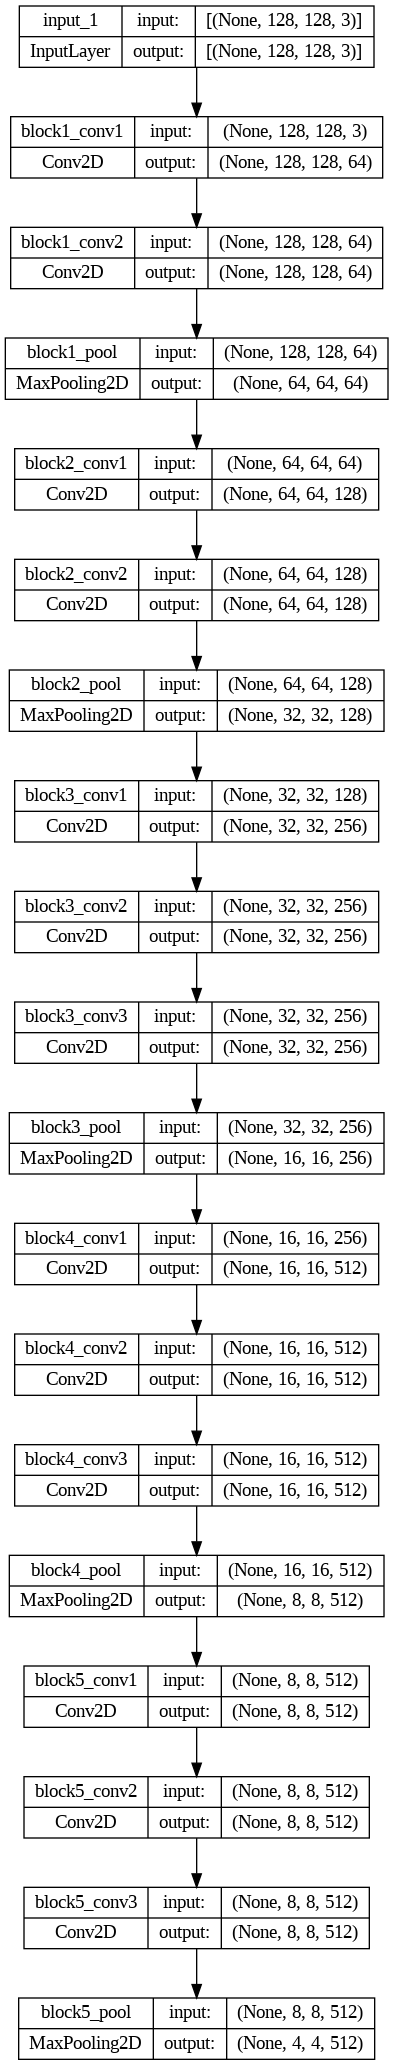

In [17]:
# 모델 구조
tf.keras.utils.plot_model(base_model, show_shapes=True)

- 만들고자 하는 U-Net의 모양을 미리 정하고, 사전 학습된 모델에서 어느 부분의 어떤 shape의 출력을 가져올지 먼저 정한다.
-  VGG16 모델의 중간 레이어 중에서 필요한 출력 텐서를 지정하여, 다양한 피처(특징)를 추출하는 인코더 모델을 정의하게 된다.
- 여기서는 VGG16 모델로부터 5개의 출력을 가져와서 사용한다.
- 다음과 같이 새로운 feature extractor 모델을 정의하고, f_model 변수에 저장한다.
- 1개의 입력과 5개의 출력을 갖는다.

In [18]:
# VGG16 중간 레이어 출력 텐서를 지정
f_model = tf.keras.Model(inputs=[base_model.input],
                         outputs=[
                                  base_model.get_layer(name='block5_conv3').output,
                                  base_model.get_layer(name='block4_conv3').output,
                                  base_model.get_layer(name='block3_conv3').output,
                                  base_model.get_layer(name='block2_conv2').output,
                                  base_model.get_layer(name='block1_conv2').output,
                         ])

- 사전 학습된 파라미터를 인코더에 그대로 사용하기 위해서 업데이트 되지 않도록 고정한다.

In [19]:
# 파라미터 고정
f_model.trainable = False

- 인코더 부분에서 5개의 출력을 가져와서 디코더의 입력으로 전달하면서 업샘플링 한다.
- 업샘플링은 축소된 이미지를 원래 이미지 크기로 복원하는 과정을 말함
- 제일 작은 (8,8,512) 텐서에서 시작해 조금씩 크기를 키워 나가며 중간 출력과 합친다.

In [21]:
# U-Net 구조로 모델 정의

i = tf.keras.Input(shape=img_shape)

out_8_8_512, out_16_16_512, out_32_32_256, out_64_64_128, out_128_128_64 = f_model(i)

out = tf.keras.layers.Conv2DTranspose(512, 3, strides=2, padding='same')(out_8_8_512)
out = tf.keras.layers.Add()([out, out_16_16_512])

out = tf.keras.layers.Conv2DTranspose(256, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_32_32_256])

out = tf.keras.layers.Conv2DTranspose(128, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_64_64_128])

out = tf.keras.layers.Conv2DTranspose(64, 3, strides=2, padding='same')(out)
out = tf.keras.layers.Add()([out, out_128_128_64])

out = tf.keras.layers.Conv2D(3, 3, activation='elu', padding='same')(out) # relu가 아닌 elu?
out = tf.keras.layers.Dense(3, activation='softmax')(out)

unet_model = tf.keras.Model(inputs=[i], outputs=[out])

- 인코더의 중간 출력이 업샘플링 과정에서 디코더의 중간 출력과 합쳐지는 것을 확인할 수 있다.
- 각 레이어의 입출력 텐서 크기를 잘 살펴본다.

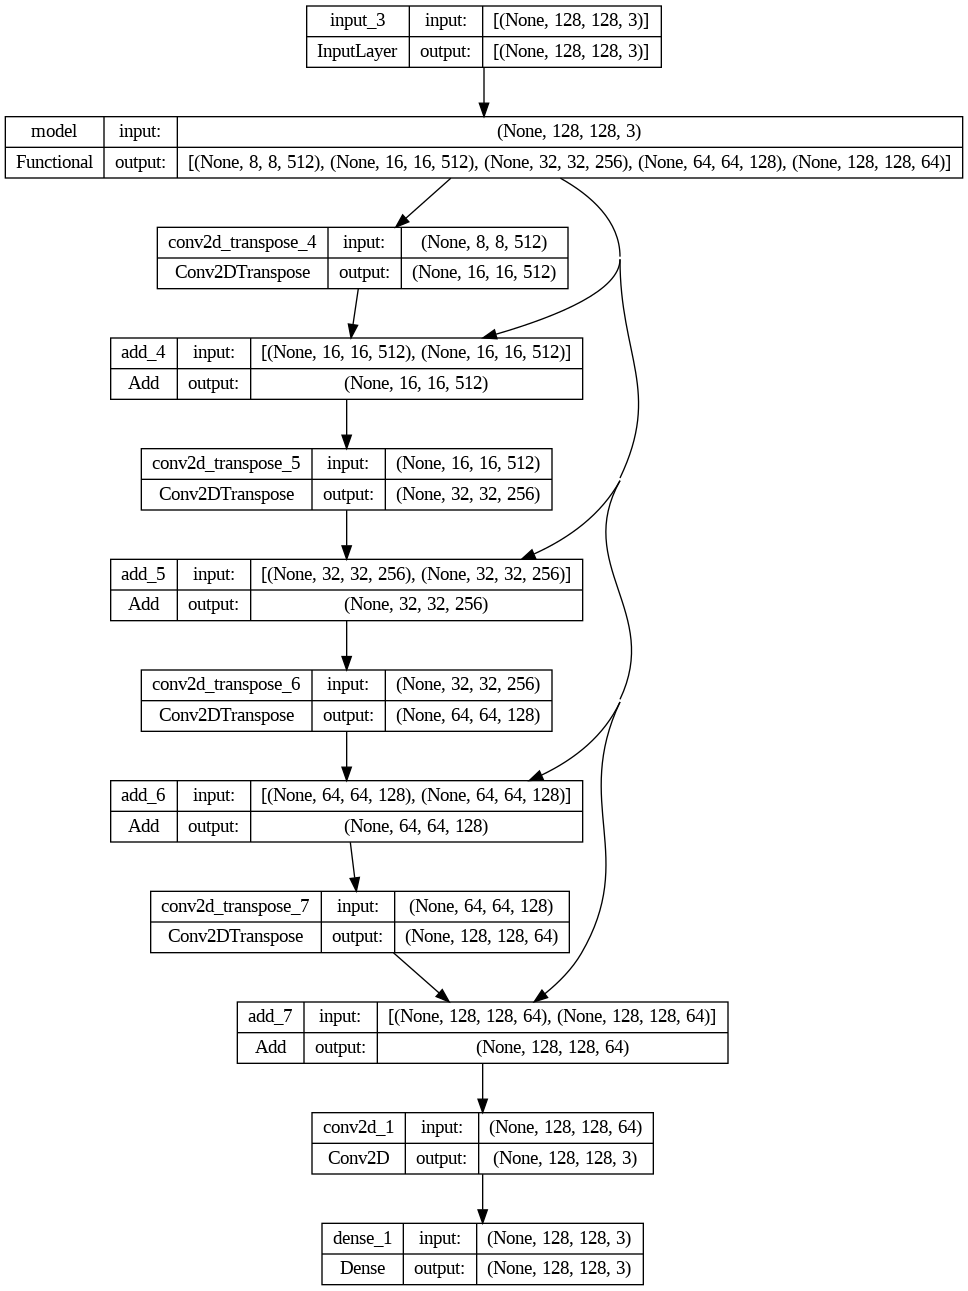

In [22]:
# 모델 구조 시각화
tf.keras.utils.plot_model(unet_model, show_shapes=True)

- 모델 구조를 요약하면 다음과 같다.
- 인코더 출력에 사용하기 위해 f_model로부터 유래하는 5개 레이어의 14,714,688개의 파라미터는 학습되지 않도록 고정돼 있다.

In [23]:
# 모델 요약
unet_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 8, 8, 512),  14714688    ['input_3[0][0]']                
                                 (None, 16, 16, 512                                               
                                ),                                                                
                                 (None, 32, 32, 256                                               
                                ),                                                          

- 예측 클래스 개수가 3개인 다중 분류 문제에 맞도록 SparseCategoricalCrossentropy 손실 함수를 설정하고, Adam 옵티마이저를 적용
- 기본 성능을 확인하는 수준에서 5 epoch만 훈련

In [ ]:
# 모델 컴파일 및 훈련
loss_f = tf.losses.SparseCategoricalCrossentropy()
opt = tf.optimizers.Adam(learning_rate)

unet_model.compile(optimizer=opt, loss=loss_f, metrics=['accuracy'])
unet_model.fit(train_ds, batch_size=batch_size, epochs=epoch_num)

Epoch 1/5
230/230 [==============================] - 1601s 7s/step - loss: 0.6423 - accuracy: 0.7086
Epoch 2/5
230/230 [==============================] - 1586s 7s/step - loss: 0.4268 - accuracy: 0.8357
Epoch 3/5
230/230 [==============================] - 1603s 7s/step - loss: 0.3986 - accuracy: 0.8455
Epoch 4/5
230/230 [==============================] - 1572s 7s/step - loss: 0.3856 - accuracy: 0.8500
Epoch 5/5
  9/230 [>.............................] - ETA: 24:37 - loss: 0.3783 - accuracy: 0.8524

- 검증 셋의 배치를 하나 선택하고 predict() 메소드로 이미지 분할 클래스를 예측한다.
- 배치를 구성하는 16개의 이미지 중에서 첫 번째 이미지의 분할 결과를 노트북에 출력한다.

In [ ]:
# 1개 배치(16개 이미지)를 선택
img, mask = next(iter(test_ds))

# 모델 예측
pred = unet_model.predict(img)

# 첫 번째 이미지 분할 결과를 출력
pred_img = np.argmax(pred[0], -1)
plt.imshow(pred_img)

- 정답 마스크 이미지를 출력하고, 앞서 예측한 분할 이미지와 비교한다.
- 어느 정도 객체의 경계를 찾아내는 것을 확인할 수 있다.

In [ ]:
# 첫 번쨰 이미지의 정답 마스크 출력
plt.imshow(np.reshape(mask[0],(128,128)))